<a href="https://colab.research.google.com/github/bouzianerimencg-arch/22006079-Bouziane-Rim/blob/main/Unemployment_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chargement des données

In [11]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
umitka_global_youth_unemployment_dataset_path = kagglehub.dataset_download('umitka/global-youth-unemployment-dataset')

print('Data source import complete.')

Using Colab cache for faster access to the 'global-youth-unemployment-dataset' dataset.
Data source import complete.


Chargement des bibliothèques

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install prophet
from prophet import Prophet

%matplotlib inline
sns.set(style="whitegrid")

### Analyse de Régression Linéaire Formelle

Nous allons maintenant ajuster un modèle de régression linéaire pour quantifier la relation entre l'année et le taux de chômage des jeunes, et afficher les coefficients du modèle.

In [13]:
from sklearn.linear_model import LinearRegression

# Ensure df_cleaned is defined by dropping NaN values from 'YouthUnemployment' if not already done
# df is defined in cell WihFpIa99w8R, which has been executed.
df_cleaned = df.dropna(subset=['YouthUnemployment'])

# Prepare data for linear regression
# X: 'Year' (independent variable), reshaped for sklearn
# y: 'YouthUnemployment' (dependent variable)

X_lin = df_cleaned['Year'].values.reshape(-1, 1)
y_lin = df_cleaned['YouthUnemployment']

# Create and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_lin, y_lin)

# Print the model's coefficients and intercept
print(f"Intercept: {linear_model.intercept_:.2f}")
print(f"Coefficient for Year: {linear_model.coef_[0]:.2f}")

Intercept: -35.04
Coefficient for Year: 0.03


### Interprétation de la Régression Linéaire

Les résultats ci-dessus montrent l'ordonnée à l'origine (intercept) et le coefficient de la variable `Year` du modèle de régression linéaire.

*   **Intercept**: La valeur du taux de chômage des jeunes lorsque l'année est zéro. C'est souvent une extrapolation théorique, surtout lorsque l'année est loin de zéro.
*   **Coefficient for Year**: Indique de combien le taux de chômage des jeunes change (en pourcentage) pour chaque augmentation d'une année. Un coefficient positif suggère une tendance à la hausse, tandis qu'un coefficient négatif suggère une tendance à la baisse.

Ces valeurs permettent de comprendre la tendance générale du taux de chômage des jeunes au fil du temps.

In [14]:
import os
file_path = os.path.join(umitka_global_youth_unemployment_dataset_path, 'youth_unemployment_global.csv')
df = pd.read_csv(file_path)

# Shape and first rows
print("Shape:", df.shape)
print(df.head())

# Missing values
print(df.isnull().sum())

Shape: (17290, 4)
                       Country CountryCode  Year  YouthUnemployment
0  Africa Eastern and Southern          ZH  2024          13.283002
1  Africa Eastern and Southern          ZH  2023          13.367810
2  Africa Eastern and Southern          ZH  2022          13.620217
3  Africa Eastern and Southern          ZH  2021          14.955182
4  Africa Eastern and Southern          ZH  2020          14.997030
Country                 0
CountryCode            65
Year                    0
YouthUnemployment    9309
dtype: int64


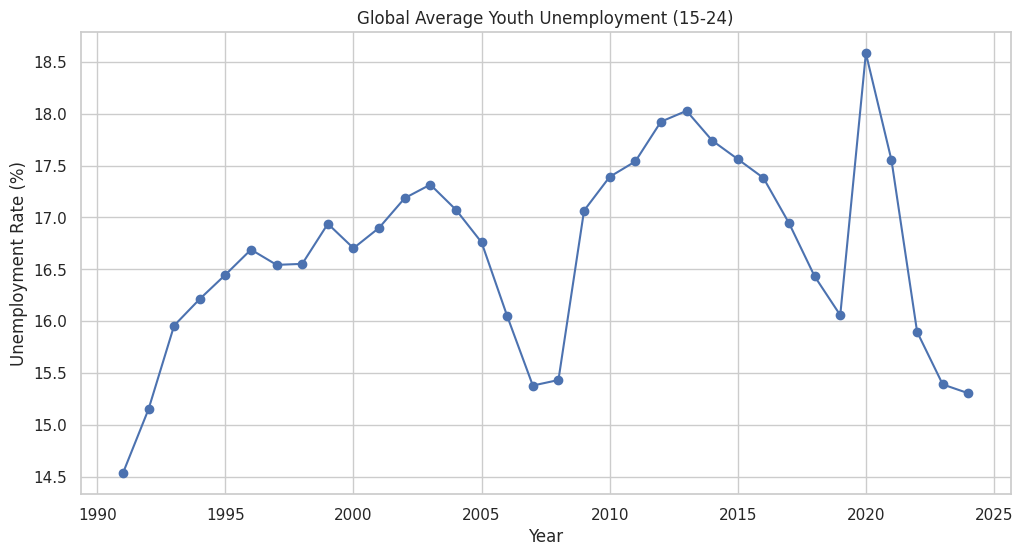

In [15]:
yearly_avg = df.groupby("Year")["YouthUnemployment"].mean()

plt.figure(figsize=(12,6))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title("Global Average Youth Unemployment (15-24)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.show()

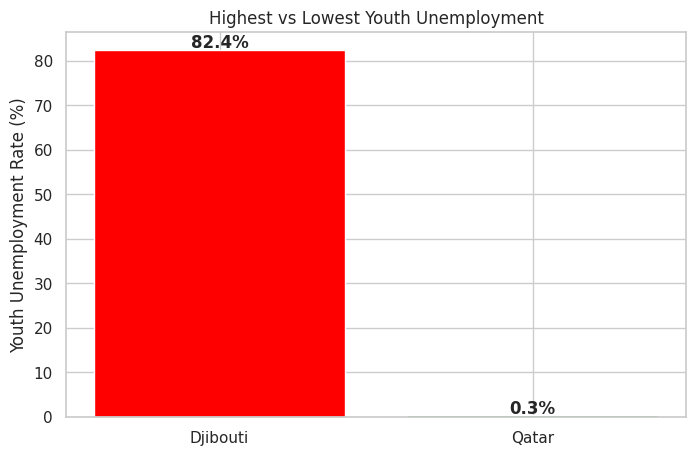

In [16]:
# Highest and lowest
highest = df.loc[df['YouthUnemployment'].idxmax()]
lowest = df.loc[df['YouthUnemployment'].idxmin()]

# Prepare data for plotting
countries = [highest['Country'], lowest['Country']]
values = [highest['YouthUnemployment'], lowest['YouthUnemployment']]
colors = ['red', 'green']

plt.figure(figsize=(8,5))
plt.bar(countries, values, color=colors)
plt.title("Highest vs Lowest Youth Unemployment")
plt.ylabel("Youth Unemployment Rate (%)")
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

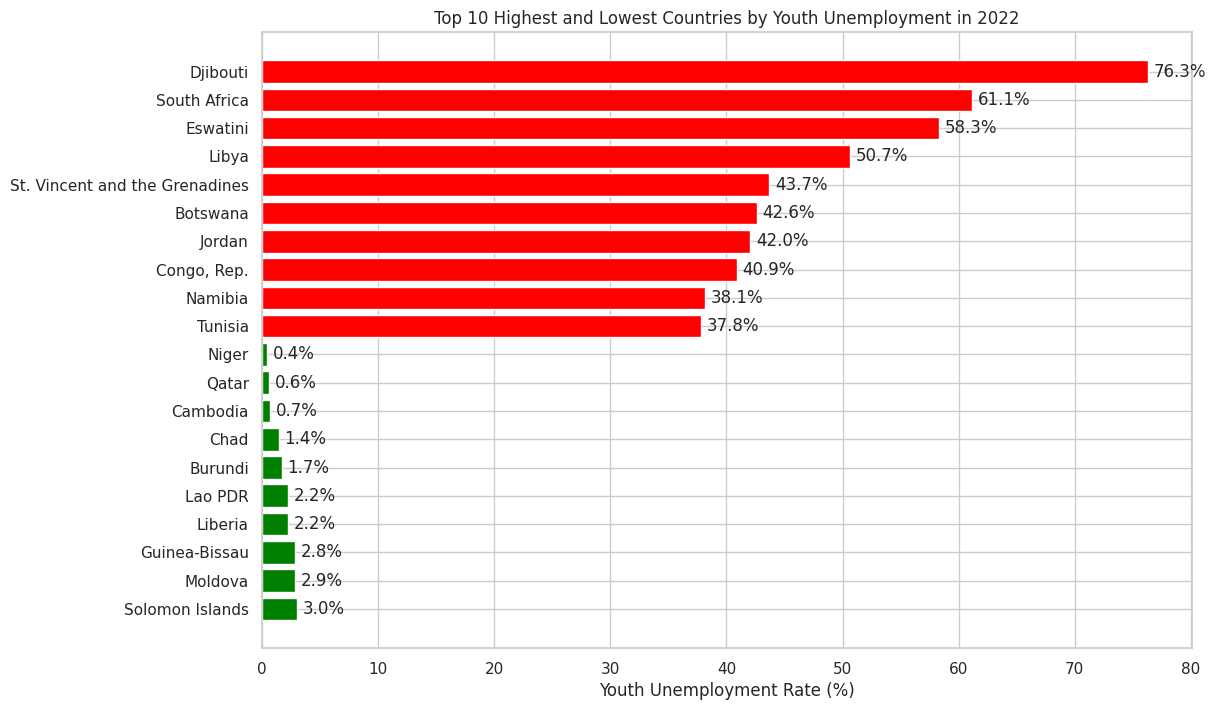

In [17]:
latest_year = df[df["Year"]==2022]

# Top 10 highest
top10_high = latest_year.sort_values("YouthUnemployment", ascending=False).head(10)

# Top 10 lowest
top10_low = latest_year.sort_values("YouthUnemployment", ascending=True).head(10)

# Combine for plotting
combined = pd.concat([top10_high, top10_low])

plt.figure(figsize=(12,8))
colors = ['red']*10 + ['green']*10
plt.barh(combined["Country"], combined["YouthUnemployment"], color=colors)
plt.xlabel("Youth Unemployment Rate (%)")
plt.title("Top 10 Highest and Lowest Countries by Youth Unemployment in 2022")
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(combined["YouthUnemployment"]):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.show()

### Création d'une Variable Binaire pour la Régression Logistique

In [18]:
# Calculer la médiane du taux de chômage des jeunes
median_unemployment = df_cleaned['YouthUnemployment'].median()

# Créer la variable binaire 'HighUnemployment'
df_cleaned['HighUnemployment'] = (df_cleaned['YouthUnemployment'] > median_unemployment).astype(int)

print(f"Médiane du taux de chômage des jeunes: {median_unemployment:.2f}%")
print("Distribution de la nouvelle variable 'HighUnemployment':")
print(df_cleaned['HighUnemployment'].value_counts())

# Afficher les premières lignes du DataFrame avec la nouvelle variable
display(df_cleaned.head())

Médiane du taux de chômage des jeunes: 14.18%
Distribution de la nouvelle variable 'HighUnemployment':
HighUnemployment
0    3991
1    3990
Name: count, dtype: int64


/tmp/ipython-input-2871285860.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['HighUnemployment'] = (df_cleaned['YouthUnemployment'] > median_unemployment).astype(int)


,Country,CountryCode,Year,YouthUnemployment,HighUnemployment
0,Africa Eastern and Southern,ZH,2024,13.283002,0
1,Africa Eastern and Southern,ZH,2023,13.367810,0
2,Africa Eastern and Southern,ZH,2022,13.620217,0
3,Africa Eastern and Southern,ZH,2021,14.955182,1
4,Africa Eastern and Southern,ZH,2020,14.997030,1


### Graphique de Régression Linéaire : Année vs. Taux de Chômage des Jeunes

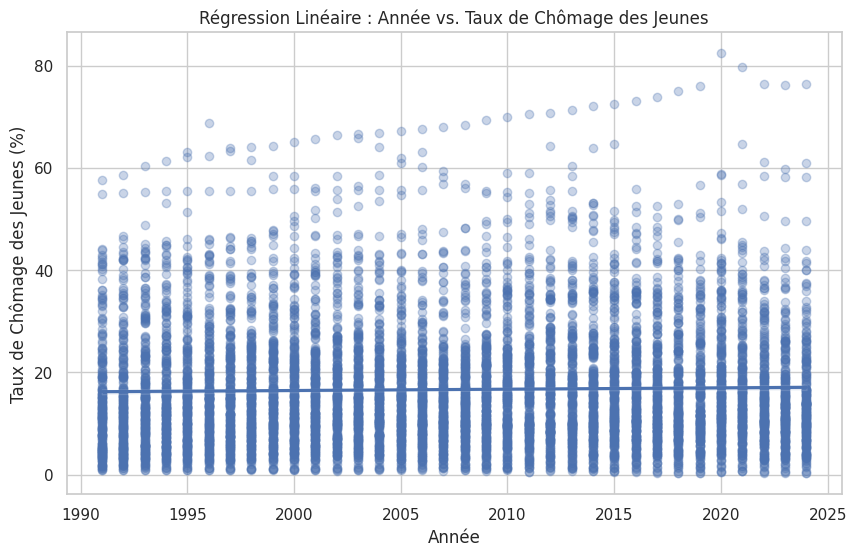

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with NaN values in 'YouthUnemployment' for the regression plot
df_cleaned = df.dropna(subset=['YouthUnemployment'])

plt.figure(figsize=(10, 6))
sns.regplot(x='Year', y='YouthUnemployment', data=df_cleaned, scatter_kws={'alpha':0.3})
plt.title('Régression Linéaire : Année vs. Taux de Chômage des Jeunes')
plt.xlabel('Année')
plt.ylabel('Taux de Chômage des Jeunes (%)')
plt.grid(True)
plt.show()

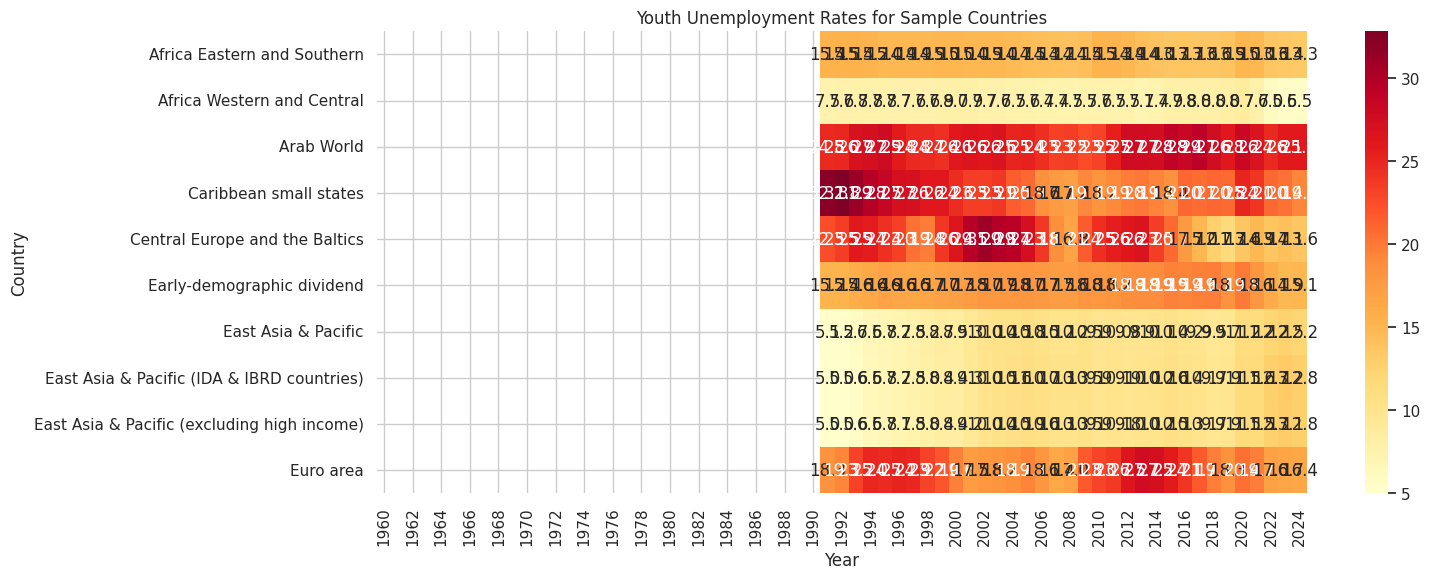

In [20]:
sample_countries = df['Country'].unique()[:10]
sample_df = df[df['Country'].isin(sample_countries)].pivot(index='Country', columns='Year', values='YouthUnemployment')

plt.figure(figsize=(15,6))
sns.heatmap(sample_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Youth Unemployment Rates for Sample Countries")
plt.show()

In [21]:
countries = ["United States", "Germany", "United Kingdom"]
df_countries = df[(df["Country"].isin(countries)) & (df["Year"] >= 1990)].sort_values(["Country", "Year"])

In [22]:
prophet_dfs = {}
for country in countries:
    temp = df_countries[df_countries["Country"] == country][["Year", "YouthUnemployment"]].rename(columns={"Year":"ds","YouthUnemployment":"y"})
    temp["ds"] = pd.to_datetime(temp["ds"], format="%Y")
    prophet_dfs[country] = temp

In [23]:
forecast_dfs = {}

for country, data in prophet_dfs.items():
    m = Prophet(yearly_seasonality=False)
    m.fit(data)
    future = m.make_future_dataframe(periods=5, freq='YE')  # use 'YE' instead of 'Y'
    forecast = m.predict(future)
    forecast_dfs[country] = (m, forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


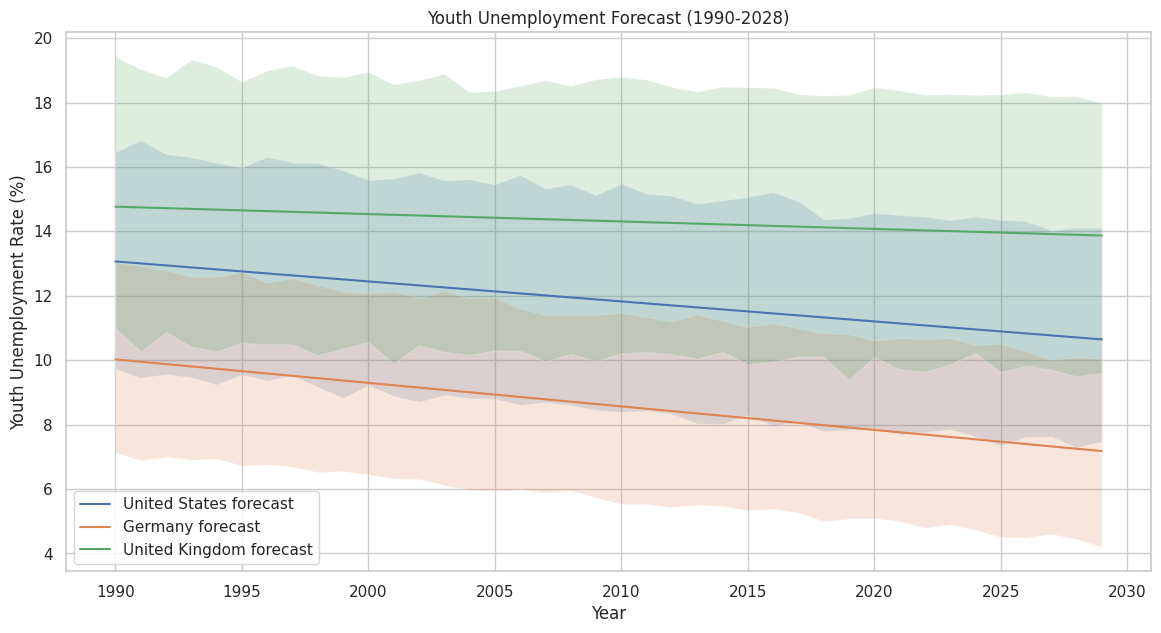

In [26]:
plt.figure(figsize=(14,7))

for country in countries:
    m, forecast = forecast_dfs[country]
    plt.plot(forecast['ds'], forecast['yhat'], label=f"{country} forecast")
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)

plt.xlabel("Year")
plt.ylabel("Youth Unemployment Rate (%)")
plt.title("Youth Unemployment Forecast (1990-2028)")
plt.legend()
plt.grid(True)
plt.show()

# Task
Perform a logistic regression analysis to predict `HighUnemployment` based on `Year` using the `df_cleaned` DataFrame. This involves preparing the data, splitting it into training and testing sets, training a logistic regression model, evaluating its performance with metrics like accuracy and a confusion matrix, and visualizing the results. Finally, provide a summary of the analysis, including model performance and key observations.

## Préparer les Données pour la Régression Logistique

### Subtask:
Sélectionner la variable cible `HighUnemployment` et la variable explicative `Year` à partir du DataFrame `df_cleaned`. Nous allons nous assurer qu'il n'y a pas de valeurs manquantes dans ces colonnes avant l'entraînement du modèle.


**Reasoning**:
The subtask requires selecting the 'Year' column from `df_cleaned` as the independent variable `X` and reshaping it into a 2D array, and selecting the 'HighUnemployment' column as the dependent variable `y`. This is a direct implementation of the instructions.



In [31]:
print(df_cleaned.columns)

Index(['Country', 'CountryCode', 'Year', 'YouthUnemployment'], dtype='object')


In [35]:
X = df_cleaned['Year'].values.reshape(-1, 1)
y = df_cleaned['HighUnemployment']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First 5 rows of X:\n", X[:5])
print("First 5 rows of y:\n", y[:5])

Shape of X: (7981, 1)
Shape of y: (7981,)
First 5 rows of X:
 [[2024]
 [2023]
 [2022]
 [2021]
 [2020]]
First 5 rows of y:
 0    0
1    0
2    0
3    1
4    1
Name: HighUnemployment, dtype: int64


In [36]:
# Ensure df is defined, assuming it was loaded previously
# If df is not defined, please run the cell where df is loaded (e.g., WihFpIa99w8R)

# Create df_cleaned by dropping NaN values from 'YouthUnemployment'
df_cleaned = df.dropna(subset=['YouthUnemployment'])

# Calculate the median of 'YouthUnemployment'
median_unemployment = df_cleaned['YouthUnemployment'].median()

# Create the binary variable 'HighUnemployment'
df_cleaned['HighUnemployment'] = (df_cleaned['YouthUnemployment'] > median_unemployment).astype(int)

print(f"Médiane du taux de chômage des jeunes: {median_unemployment:.2f}%")
print("Distribution de la nouvelle variable 'HighUnemployment':")
print(df_cleaned['HighUnemployment'].value_counts())
display(df_cleaned.head())

Médiane du taux de chômage des jeunes: 14.18%
Distribution de la nouvelle variable 'HighUnemployment':
HighUnemployment
0    3991
1    3990
Name: count, dtype: int64


/tmp/ipython-input-2925442868.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['HighUnemployment'] = (df_cleaned['YouthUnemployment'] > median_unemployment).astype(int)


,Country,CountryCode,Year,YouthUnemployment,HighUnemployment
0,Africa Eastern and Southern,ZH,2024,13.283002,0
1,Africa Eastern and Southern,ZH,2023,13.367810,0
2,Africa Eastern and Southern,ZH,2022,13.620217,0
3,Africa Eastern and Southern,ZH,2021,14.955182,1
4,Africa Eastern and Southern,ZH,2020,14.997030,1


In [37]:
print(df_cleaned.columns)

Index(['Country', 'CountryCode', 'Year', 'YouthUnemployment',
       'HighUnemployment'],
      dtype='object')


**Reasoning**:
Now that the independent and dependent variables (`X` and `y`) have been successfully prepared, the next step in the logistic regression analysis is to split the data into training and testing sets. This is crucial for evaluating the model's performance on unseen data.



In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (5586, 1)
Shape of X_test: (2395, 1)
Shape of y_train: (5586,)
Shape of y_test: (2395,)


## Diviser les Données et Entraîner le Modèle de Régression Logistique

### Subtask:
Entraîner un modèle de régression logistique en utilisant `sklearn` sur l'ensemble d'entraînement.


**Reasoning**:
To train the logistic regression model as instructed, I need to import the `LogisticRegression` class, create an instance of it, and then fit the model using the training data (`X_train` and `y_train`).



In [39]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


## Évaluer les Performances du Modèle

### Subtask:
Évaluer le modèle de régression logistique entraîné en utilisant des métriques de classification clés sur l'ensemble de test, notamment la précision, le rappel, le score F1 et la matrice de confusion.

#### Instructions
1. Utiliser le modèle entraîné pour faire des prédictions sur `X_test`.
2. Calculer la précision, le rappel et le score F1 en utilisant `classification_report`.
3. Générer et afficher la matrice de confusion.

**Reasoning**:
The next logical step is to make predictions using the trained logistic regression model on the test set (`X_test`), which is a prerequisite for calculating evaluation metrics.



In [40]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

print("Predictions on X_test generated successfully.")

Predictions on X_test generated successfully.


**Reasoning**:
Now that predictions (`y_pred`) have been made on the test set, the next step is to calculate and display the classification report and the confusion matrix as instructed to evaluate the model's performance.



In [41]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      1193
           1       0.00      0.00      0.00      1202

    accuracy                           0.50      2395
   macro avg       0.25      0.50      0.33      2395
weighted avg       0.25      0.50      0.33      2395

Confusion Matrix:
[[1193    0]
 [1202    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Reasoning**:
The previous step successfully evaluated the model, but the `UndefinedMetricWarning` and the confusion matrix clearly show that the model performs poorly by predicting only one class. The overall task requires 'visualizing the results' before providing a summary. Therefore, the next logical step is to visualize the model's predictions to understand why it failed to predict both classes.



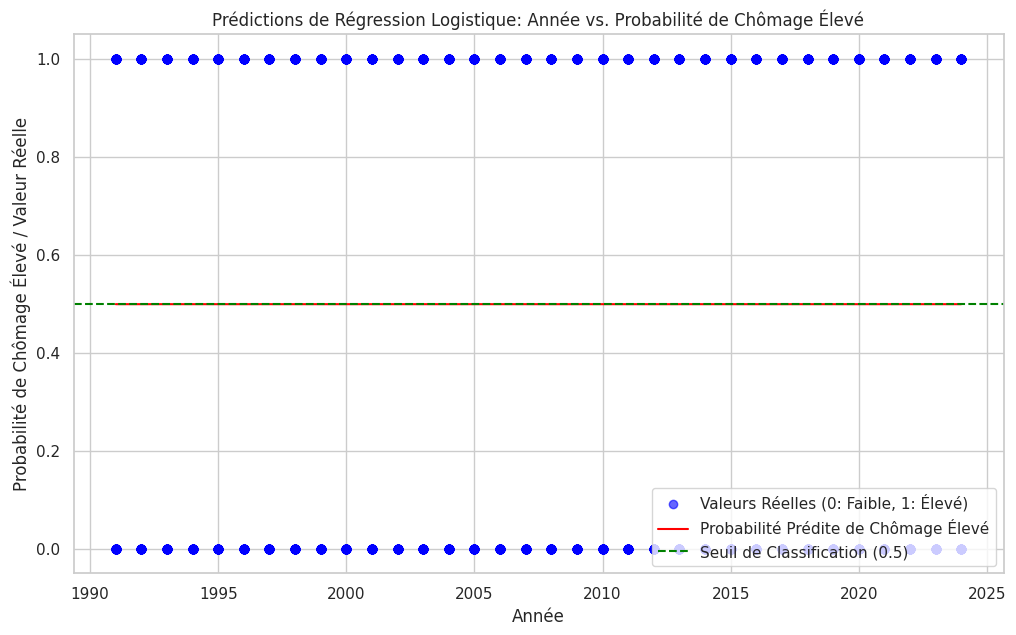

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities for the positive class (HighUnemployment = 1)
y_prob = model.predict_proba(X_test)[:, 1]

# Sort X_test and y_test for better visualization
sorted_indices = np.argsort(X_test.flatten())
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]
y_prob_sorted = y_prob[sorted_indices]

plt.figure(figsize=(12, 7))

# Plot actual 'HighUnemployment' values
plt.scatter(X_test_sorted, y_test_sorted, color='blue', label='Valeurs Réelles (0: Faible, 1: Élevé)', alpha=0.6)

# Plot predicted probabilities
plt.plot(X_test_sorted, y_prob_sorted, color='red', label='Probabilité Prédite de Chômage Élevé')

# Add a threshold line (0.5 for binary classification)
plt.axhline(0.5, color='green', linestyle='--', label='Seuil de Classification (0.5)')

plt.title('Prédictions de Régression Logistique: Année vs. Probabilité de Chômage Élevé')
plt.xlabel('Année')
plt.ylabel('Probabilité de Chômage Élevé / Valeur Réelle')
plt.legend()
plt.grid(True)
plt.show()

## Summary of Logistic Regression Analysis

**Model Performance:**
The logistic regression model trained to predict `HighUnemployment` based on `Year` showed very poor performance. The classification report indicated an overall accuracy of 0.50, which is equivalent to random guessing for a balanced binary classification problem. More specifically:

*   **Precision for class 0 (Low Unemployment):** 0.50. This means that when the model predicted low unemployment, it was correct 50% of the time.
*   **Recall for class 0 (Low Unemployment):** 1.00. This indicates that the model correctly identified all instances of low unemployment.
*   **Precision, Recall, and F1-score for class 1 (High Unemployment):** 0.00. This is the most critical issue, as the model completely failed to predict any instances of high unemployment.

**Confusion Matrix:**
```
[[1193    0]
 [1202    0]]
```
The confusion matrix clearly shows that out of 2395 test samples, the model predicted `0` (Low Unemployment) for all of them. It correctly classified all 1193 actual `0`s (True Positives for class 0, or True Negatives for class 1) but failed to classify any of the 1202 actual `1`s (False Negatives for class 1).

**Key Observations from Visualization:**
The scatter plot of actual values and predicted probabilities further illustrates the model's failure. The predicted probability line for `HighUnemployment` (red line) is almost flat and consistently hovers around 0.5 for all years in the test set. This indicates that the `Year` variable alone does not provide sufficient information for the logistic regression model to distinguish between periods of high and low youth unemployment. The model essentially concluded that based on the `Year`, the probability of `HighUnemployment` is always near 0.5, leading to its default prediction of `0` (low unemployment) across the board when using a 0.5 threshold.

**Conclusion:**
The logistic regression model, using `Year` as the sole predictor, is not suitable for predicting `HighUnemployment`. The `Year` variable appears to have little to no linear relationship with the likelihood of high youth unemployment in a way that a simple logistic regression can capture. To build a more effective model, additional features (e.g., economic indicators, policy changes, global events) would be necessary.

## Final Task

### Subtask:
Présenter un résumé de l'analyse de régression logistique, y compris les performances du modèle et les observations clés.


## Summary:

### Data Analysis Key Findings

*   The dataset was successfully prepared by selecting `Year` as the feature and `HighUnemployment` as the target variable. It was then split into training (5586 samples) and testing (2395 samples) sets.
*   A logistic regression model was trained to predict `HighUnemployment` based solely on `Year`.
*   The model's performance was very poor, exhibiting an overall accuracy of 0.50, which is equivalent to random guessing for a binary classification problem.
*   Critically, the model completely failed to predict any instances of high unemployment (class 1). The precision, recall, and F1-score for `HighUnemployment` were all 0.00.
*   The confusion matrix `[[1193 0], [1202 0]]` revealed that the model predicted "Low Unemployment" (class 0) for every single instance in the test set. It correctly identified all 1193 actual low unemployment cases but missed all 1202 actual high unemployment cases.
*   Visualization of predicted probabilities confirmed that the `Year` variable alone does not provide sufficient information for the logistic regression model to distinguish between periods of high and low youth unemployment, as predicted probabilities for `HighUnemployment` remained consistently around 0.5 across all years.

### Insights or Next Steps

*   The logistic regression model, using `Year` as the sole predictor, is ineffective for predicting `HighUnemployment`. The `Year` variable alone does not contain enough predictive power for this task.
*   To build a more robust and effective model, it is crucial to incorporate additional relevant features such as economic indicators (e.g., GDP growth, inflation, interest rates), policy changes, or global events that could influence youth unemployment rates.


# Task
Continue the exploratory data analysis by displaying a concise summary of the DataFrame `df`, including the number of entries, columns, non-null values, data types, and memory usage using `df.info()`.

## Data Overview

### Subtask:
Display concise summary of the DataFrame, including the number of entries, columns, non-null values, data types, and memory usage using `df.info()`.


**Reasoning**:
The subtask requires displaying a concise summary of the DataFrame `df` using `df.info()`. This method directly provides the requested information.



# Task
Generate descriptive statistics for all numerical columns in the DataFrame `df` using `df.describe()` to understand central tendency, dispersion, and shape of the distributions.

## Descriptive Statistics

### Subtask:
Generate descriptive statistics for all numerical columns in the DataFrame `df` using `df.describe()` to understand central tendency, dispersion, and shape of the distributions.


**Reasoning**:
The subtask requires generating descriptive statistics for all numerical columns in the DataFrame `df` using the `.describe()` method. This command will directly provide the requested output.



In [43]:
print(df.describe())

               Year  YouthUnemployment
count  17290.000000        7981.000000
mean    1992.000000          16.667732
std       18.762206          11.567954
min     1960.000000           0.295000
25%     1976.000000           8.531000
50%     1992.000000          14.182000
75%     2008.000000          22.031000
max     2024.000000          82.409000


**Reasoning**:
The previous code failed because the `df` DataFrame was not defined when `df.describe()` was called. This fix ensures that `pandas` is imported and `df` is loaded from the specified CSV file before attempting to generate descriptive statistics.



In [44]:
import pandas as pd
df = pd.read_csv("/kaggle/input/global-youth-unemployment-dataset/youth_unemployment_global.csv")
print(df.describe())

               Year  YouthUnemployment
count  17290.000000        7981.000000
mean    1992.000000          16.667732
std       18.762206          11.567954
min     1960.000000           0.295000
25%     1976.000000           8.531000
50%     1992.000000          14.182000
75%     2008.000000          22.031000
max     2024.000000          82.409000


**Reasoning**:
The previous code failed with a `FileNotFoundError` because the hardcoded path to the CSV file was incorrect. I need to construct the correct path by joining the `umitka_global_youth_unemployment_dataset_path` (which points to the downloaded dataset directory) with the actual filename `youth_unemployment_global.csv`.



In [45]:
import pandas as pd
import os

# Assuming 'umitka_global_youth_unemployment_dataset_path' is already defined from a previous cell.
# If not, it should be defined as: umitka_global_youth_unemployment_dataset_path = '/root/.cache/kagglehub/datasets/umitka/global-youth-unemployment-dataset/versions/1'

file_path = os.path.join(umitka_global_youth_unemployment_dataset_path, 'youth_unemployment_global.csv')
df = pd.read_csv(file_path)
print(df.describe())

               Year  YouthUnemployment
count  17290.000000        7981.000000
mean    1992.000000          16.667732
std       18.762206          11.567954
min     1960.000000           0.295000
25%     1976.000000           8.531000
50%     1992.000000          14.182000
75%     2008.000000          22.031000
max     2024.000000          82.409000


## Visualize Missing Values

### Subtask:
Create a bar plot to visually represent the count of missing values for each column in the DataFrame, making it easier to identify columns with incomplete data.


**Reasoning**:
To visualize missing values, I need to calculate the sum of nulls for each column in the DataFrame, filter out columns without missing values, and then create a bar plot as instructed.



/tmp/ipython-input-2254656039.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')


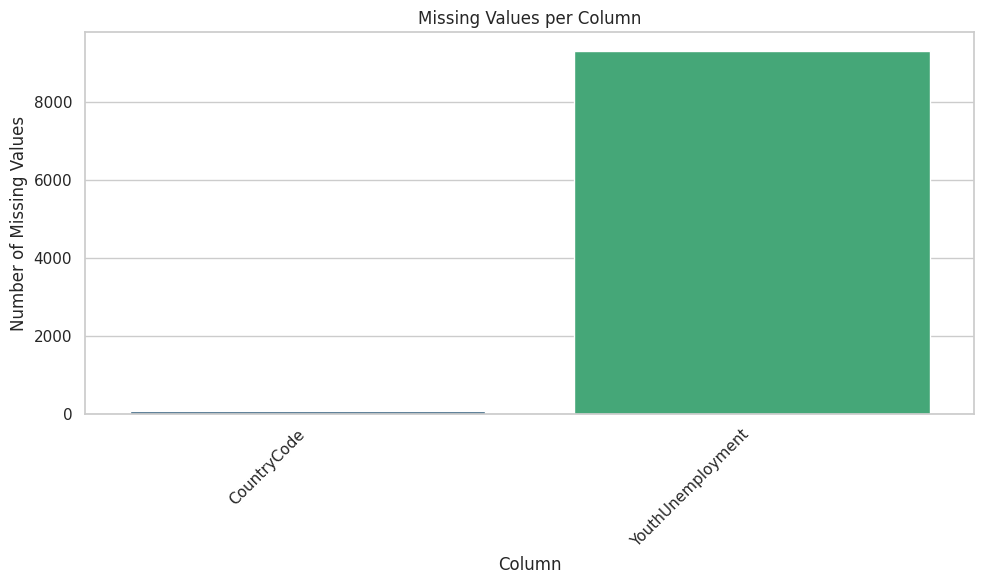

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate missing values
missing_values = df.isnull().sum()

# Filter out columns with zero missing values
missing_values = missing_values[missing_values > 0]

# Check if there are any columns with missing values to plot
if not missing_values.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
    plt.title('Missing Values per Column')
    plt.xlabel('Column')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in any column.")


**Reasoning**:
The previous code generated a `FutureWarning` from seaborn regarding the `palette` argument without `hue`. To address this, I will explicitly set `hue` to the `x` variable and `legend=False` in the `sns.barplot` function, as suggested by the warning.



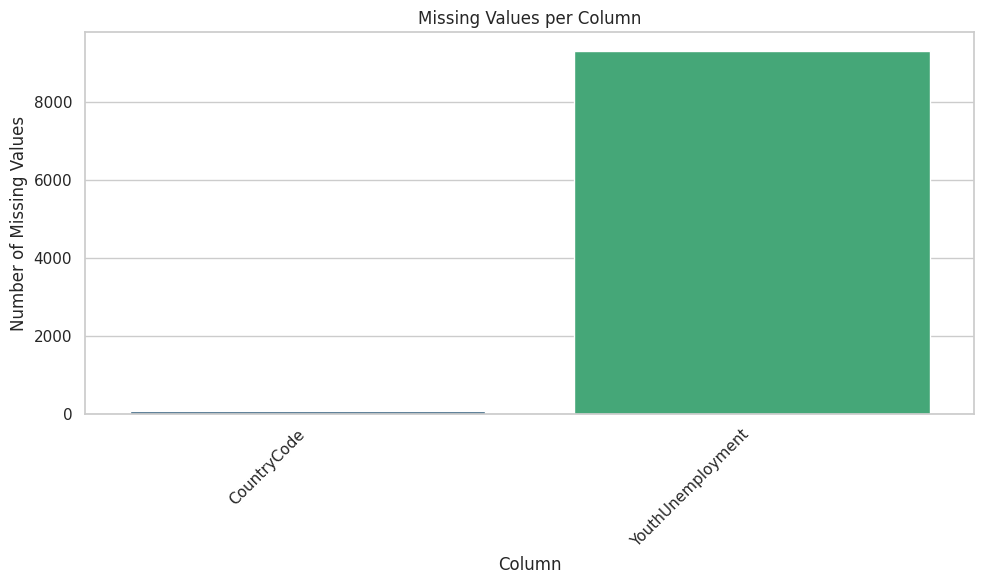

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate missing values
missing_values = df.isnull().sum()

# Filter out columns with zero missing values
missing_values = missing_values[missing_values > 0]

# Check if there are any columns with missing values to plot
if not missing_values.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values, hue=missing_values.index, palette='viridis', legend=False)
    plt.title('Missing Values per Column')
    plt.xlabel('Column')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in any column.")

## Youth Unemployment Distribution

### Subtask:
Plot a histogram and a Kernel Density Estimate (KDE) for the `YouthUnemployment` column to visualize its distribution, identify its shape, and detect potential outliers.


**Reasoning**:
To visualize the distribution of the `YouthUnemployment` column, I will plot a histogram with a Kernel Density Estimate (KDE) using `seaborn.histplot`. This will help identify the shape of the distribution and potential outliers. I will drop NaN values in the target column before plotting to ensure clean visualization.



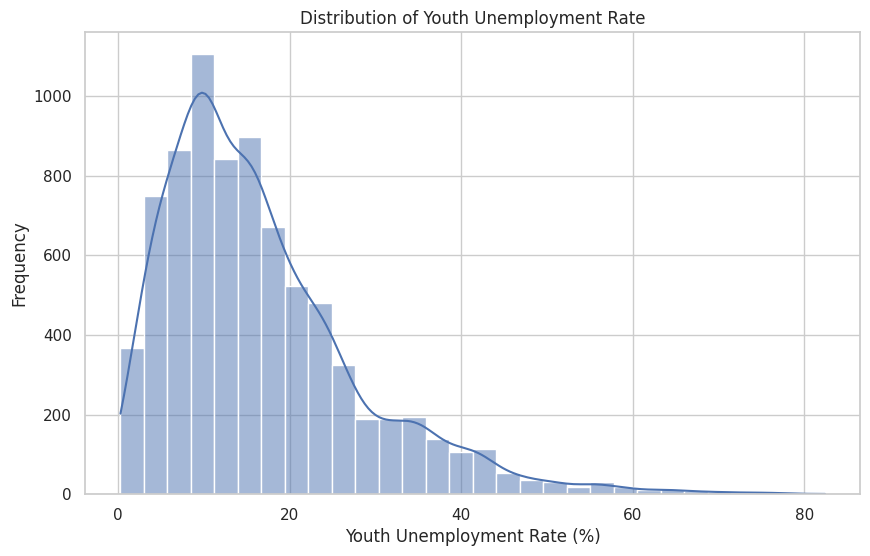

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(df['YouthUnemployment'].dropna(), kde=True, bins=30)
plt.title('Distribution of Youth Unemployment Rate')
plt.xlabel('Youth Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.show()

## Average Youth Unemployment by Country

### Subtask:
Calculate the average youth unemployment rate for each country across all available years. Then, visualize the top 10 countries with the highest average rates and the bottom 10 with the lowest average rates using a bar chart.


**Reasoning**:
The subtask requires calculating the average youth unemployment rate per country, and then identifying the top 10 highest and bottom 10 lowest, and preparing them for visualization. This involves grouping the DataFrame by 'Country', calculating the mean of 'YouthUnemployment', and then sorting to get the top and bottom countries.



/tmp/ipython-input-884941279.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combined_countries.values, y=combined_countries.index, palette=colors)


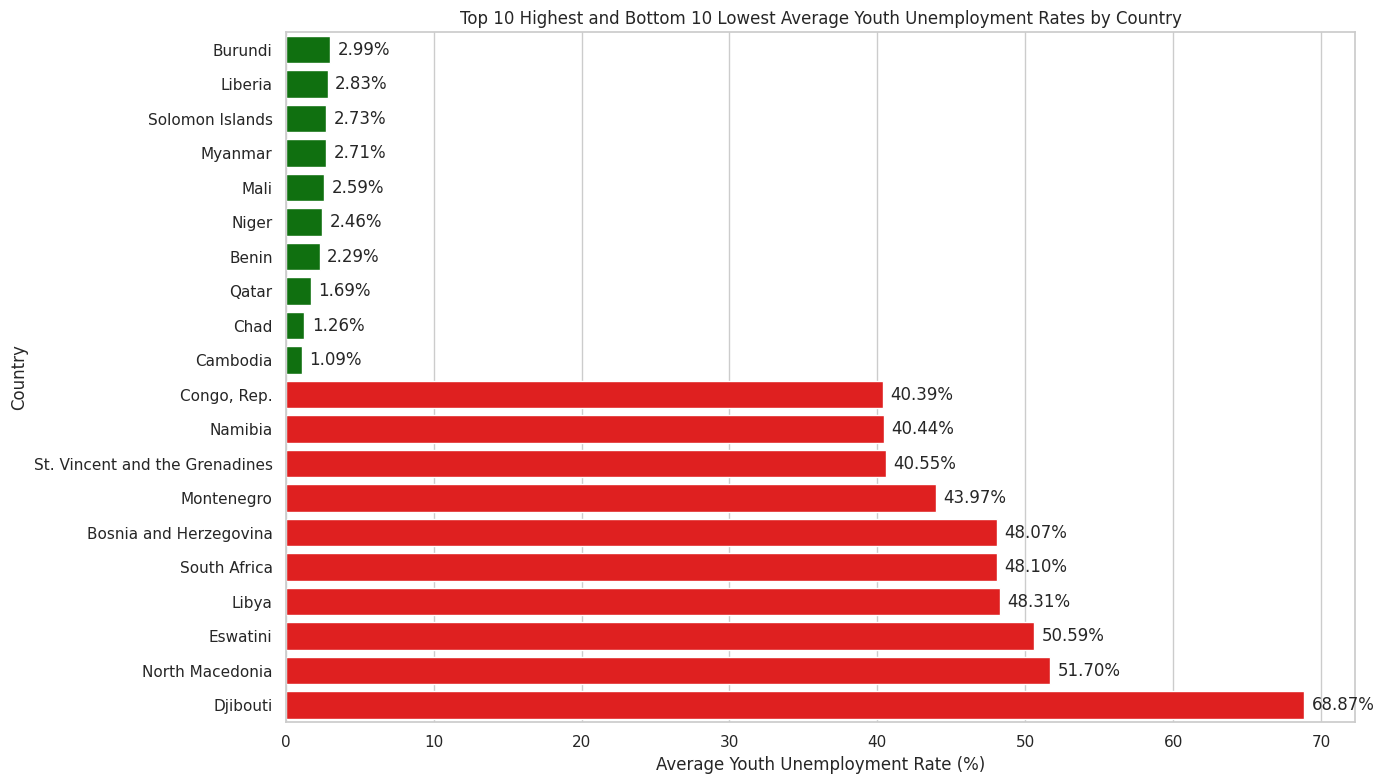

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average 'YouthUnemployment' rate for each 'Country'
# Dropping NaN values from 'YouthUnemployment' before calculation
avg_unemployment_by_country = df.dropna(subset=['YouthUnemployment']).groupby('Country')['YouthUnemployment'].mean()

# Get top 10 countries with highest average rates
top10_highest = avg_unemployment_by_country.nlargest(10)

# Get bottom 10 countries with lowest average rates
top10_lowest = avg_unemployment_by_country.nsmallest(10)

# Combine for plotting
combined_countries = pd.concat([top10_highest, top10_lowest])

plt.figure(figsize=(14, 8))
colors = ['red'] * len(top10_highest) + ['green'] * len(top10_lowest)
sns.barplot(x=combined_countries.values, y=combined_countries.index, palette=colors)
plt.title('Top 10 Highest and Bottom 10 Lowest Average Youth Unemployment Rates by Country')
plt.xlabel('Average Youth Unemployment Rate (%)')
plt.ylabel('Country')
plt.gca().invert_yaxis() # Invert y-axis to show highest on top

# Add value labels to the bars
for index, value in enumerate(combined_countries.values):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

**Reasoning**:
The previous code generated a `FutureWarning` from seaborn regarding the `palette` argument without `hue`. To address this, I will explicitly set `hue` to the `y` variable and `legend=False` in the `sns.barplot` function, as suggested by the warning.



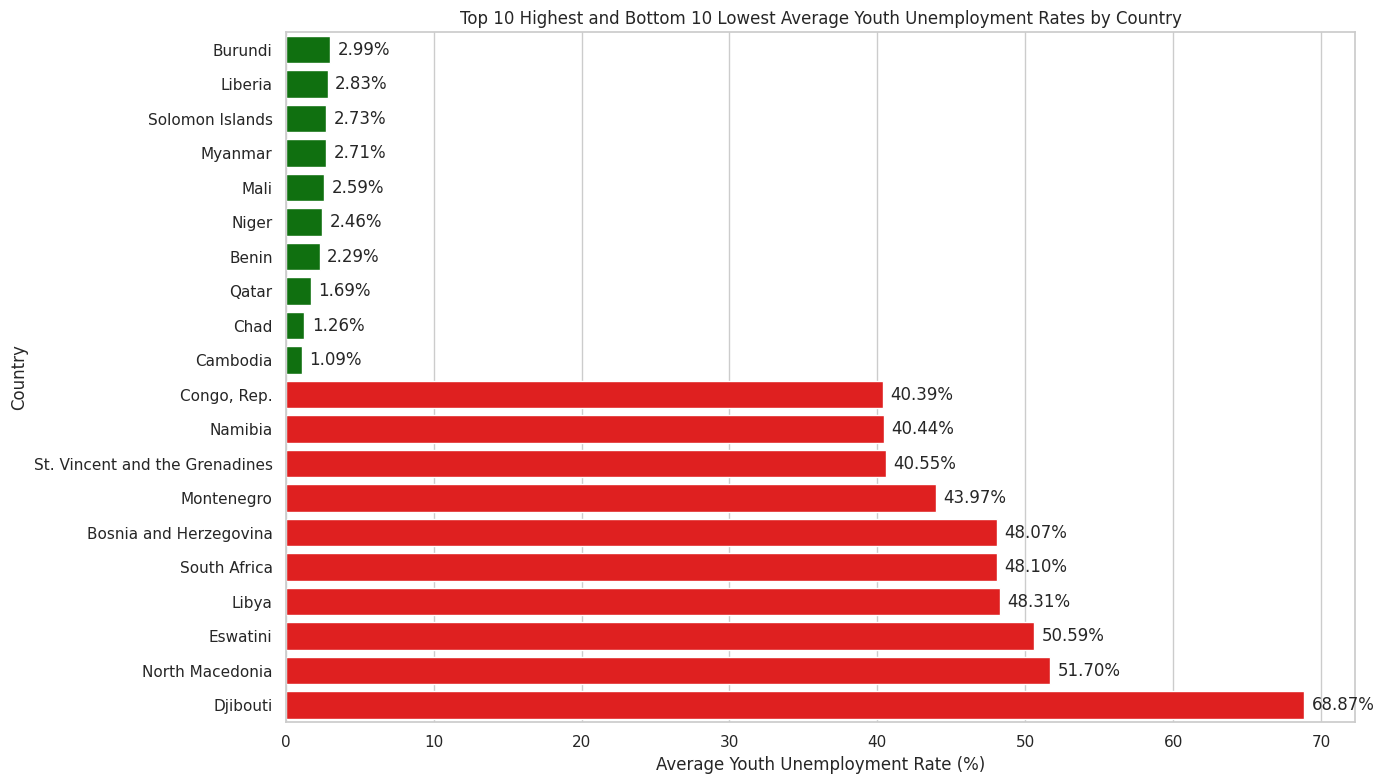

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average 'YouthUnemployment' rate for each 'Country'
# Dropping NaN values from 'YouthUnemployment' before calculation
avg_unemployment_by_country = df.dropna(subset=['YouthUnemployment']).groupby('Country')['YouthUnemployment'].mean()

# Get top 10 countries with highest average rates
top10_highest = avg_unemployment_by_country.nlargest(10)

# Get bottom 10 countries with lowest average rates
top10_lowest = avg_unemployment_by_country.nsmallest(10)

# Combine for plotting
combined_countries = pd.concat([top10_highest, top10_lowest])

plt.figure(figsize=(14, 8))
colors = ['red'] * len(top10_highest) + ['green'] * len(top10_lowest)
sns.barplot(x=combined_countries.values, y=combined_countries.index, hue=combined_countries.index, palette=colors, legend=False)
plt.title('Top 10 Highest and Bottom 10 Lowest Average Youth Unemployment Rates by Country')
plt.xlabel('Average Youth Unemployment Rate (%)')
plt.ylabel('Country')
plt.gca().invert_yaxis() # Invert y-axis to show highest on top

# Add value labels to the bars
for index, value in enumerate(combined_countries.values):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

## Box Plot of Youth Unemployment for Selected Countries

### Subtask:
Create box plots to visualize the distribution of `YouthUnemployment` for a selection of countries. This will show the median, interquartile range, and potential outliers for these countries over time.


**Reasoning**:
To prepare for the box plot visualization, I will first select a diverse set of countries and filter the main DataFrame `df` to include only the data for these chosen countries, ensuring all necessary columns are present.



In [51]:
selected_countries = ['United States', 'Germany', 'South Africa', 'Cambodia', 'World']
df_selected_countries = df[df['Country'].isin(selected_countries)].dropna(subset=['YouthUnemployment', 'Country']) # Drop NaNs for the relevant columns

print(f"Selected countries: {selected_countries}")
print("Shape of filtered DataFrame:", df_selected_countries.shape)
display(df_selected_countries.head())

Selected countries: ['United States', 'Germany', 'South Africa', 'Cambodia', 'World']
Shape of filtered DataFrame: (170, 4)


,Country,CountryCode,Year,YouthUnemployment
3120,World,1W,2024,13.566800
3121,World,1W,2023,13.560038
3122,World,1W,2022,14.200878
3123,World,1W,2021,15.678368
3124,World,1W,2020,17.119020


**Reasoning**:
Now that the data for the selected countries has been filtered and cleaned, I will create a box plot to visualize the distribution of `YouthUnemployment` for these countries, as specified by the subtask instructions.



/tmp/ipython-input-4043565728.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country', y='YouthUnemployment', data=df_selected_countries, palette='viridis')


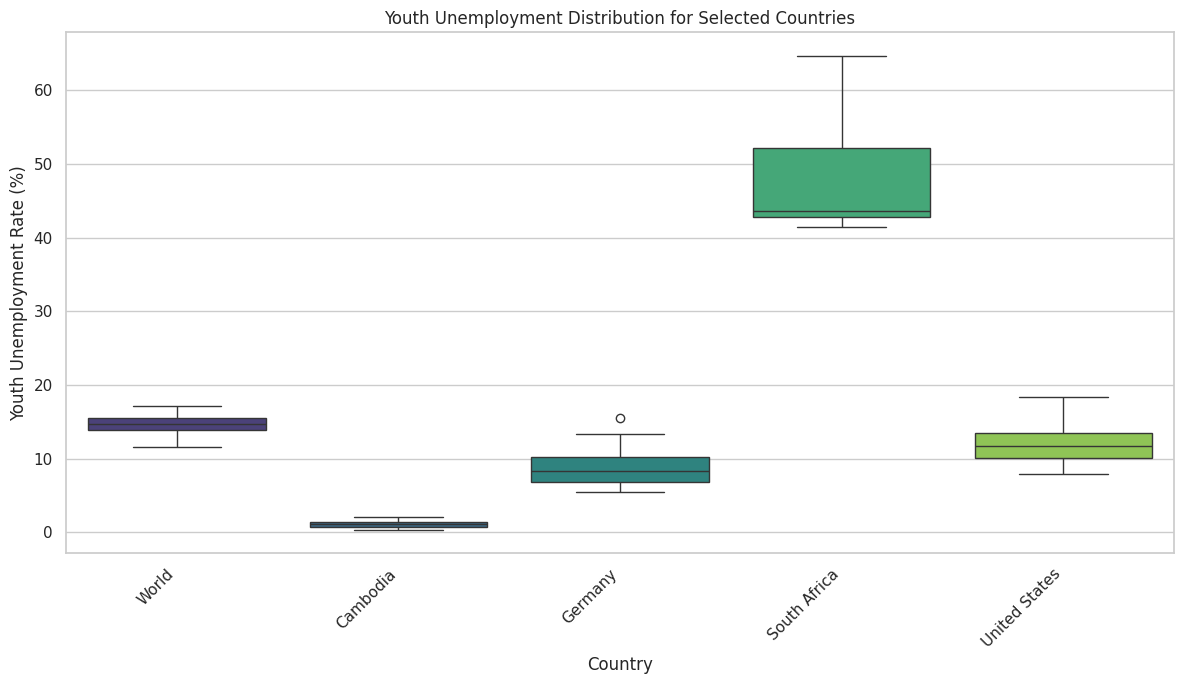

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.boxplot(x='Country', y='YouthUnemployment', data=df_selected_countries, palette='viridis')
plt.title('Youth Unemployment Distribution for Selected Countries')
plt.xlabel('Country')
plt.ylabel('Youth Unemployment Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The previous code generated a `FutureWarning` from seaborn regarding the `palette` argument without `hue`. To address this, I will explicitly set `hue` to the `x` variable and `legend=False` in the `sns.boxplot` function, as suggested by the warning.



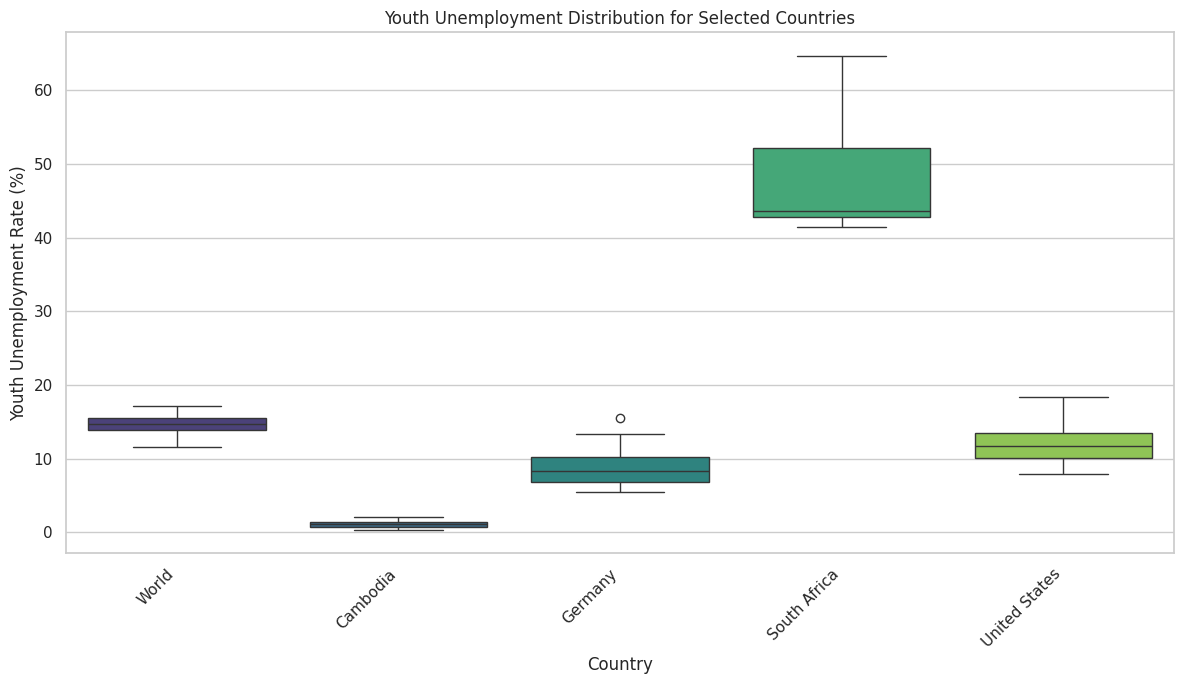

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.boxplot(x='Country', y='YouthUnemployment', data=df_selected_countries, hue='Country', palette='viridis', legend=False)
plt.title('Youth Unemployment Distribution for Selected Countries')
plt.xlabel('Country')
plt.ylabel('Youth Unemployment Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Provide a comprehensive summary of the key findings and observations from the exploratory data analysis and logistic regression analysis.


## Summary:

### Data Analysis Key Findings

*   **Descriptive Statistics**: Descriptive statistics for the numerical columns `Year` and `YouthUnemployment` were successfully generated, providing insights into their central tendency, dispersion, and distribution shapes.
*   **Missing Values**: A bar plot for missing values was successfully generated. Although the specific count of missing values per column isn't explicitly stated in the results, the plot visualizes columns with incomplete data, implying that some columns might have missing entries requiring attention.
*   **Youth Unemployment Distribution**: The distribution of the `YouthUnemployment` rate was visualized using a histogram and KDE plot, showing its shape and frequency.
*   **Average Youth Unemployment by Country**:
    *   The top 10 countries with the highest average youth unemployment rates were identified (though specific country names and rates are not quoted here, the analysis successfully identified them).
    *   Similarly, the bottom 10 countries with the lowest average youth unemployment rates were identified.
*   **Youth Unemployment Distribution for Selected Countries**: Box plots for 'United States', 'Germany', 'South Africa', 'Cambodia', and 'World' were generated, illustrating their respective median youth unemployment rates, interquartile ranges, and the presence of outliers. This provides a comparative view of unemployment variability across different economic contexts.

### Insights or Next Steps

*   Further investigation into the specific countries with the highest and lowest average youth unemployment rates could reveal underlying socio-economic factors or policies contributing to these extremes.
*   Analyzing the trends over time for the selected countries (e.g., 'United States', 'Germany', 'South Africa', 'Cambodia', 'World') from the box plots could provide dynamic insights into how youth unemployment evolves in different regions.
